# Machine Learning in TensorFlow and Keras

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/datasci-w266/2024-fall-main/blob/master/assignment/a1/TensorFlow.ipynb)

### Brief Review of Machine Learning

In supervised learning, parametric models are those where the model is a function of a fixed form with a number of unknown _parameters_.  Together with a loss function and a training set, an optimizer can select parameters to minimize the loss with respect to the training set.  Common optimizers include stochastic gradient descent.  It tweaks the parameters slightly to move the loss "downhill" due to a small batch of examples from the training set.

### Linear & Logistic Regression

You've likely seen linear regression before.  In linear regression, we fit a line (technically, hyperplane) that predicts a target variable, $y$, based on some features $x$.  The form of this model is affine (even if we call it "linear"):  

$$y_{hat} = xW + b$$

where $W$ and $b$ are weights and an offset, respectively, and are the parameters of this parametric model.  The loss function that the optimizer uses to fit these parameters is the squared error ($||\cdots||_2$) between the prediction and the ground truth in the training set.

You've also likely seen logistic regression, which is tightly related to linear regression.  Logistic regression also fits a line - this time separating the positive and negative examples of a binary classifier.  The form of this model is similar:

$$y_{hat} = \sigma(xW + b)$$

where again $W$ and $b$ are the parameters of this model, and $\sigma$ is the [sigmoid function](https://en.wikipedia.org/wiki/Sigmoid_function) which maps un-normalized scores ("logits") to values $\hat{y} \in [0,1]$ that represent probabilities. The loss function that the optimizer uses to fit these parameters is the [cross entropy](../../materials/lesson_notebook/lesson_1_NN_Review.ipynb) between the prediction and the ground truth in the training set.

This pattern of an affine transform, $xW + b$, occurs over and over in machine learning.

### Preliminaries...

Before we do anything else, let's load our data and take a quick look at it.  In this example, we're going to build a (very) simple binary classifier based on two floating point features.

In [5]:
import tensorflow as tf

# List available physical devices
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))

# Check if TensorFlow is using the GPU
if physical_devices:
    print("TensorFlow is using the GPU")
else:
    print("TensorFlow is not using the GPU")

Num GPUs Available:  1
TensorFlow is using the GPU


In [1]:
import numpy as np

def generate_data(num_train, num_test):
    np.random.seed(1)
    num = num_train + num_test
    x0 = np.random.randn(num, 2) + 3.*np.array([1, 0])
    x1 = np.random.randn(num, 2) + 1.*np.array([-1, 0])
    X = np.vstack([x0, x1])
    y = np.concatenate([
        np.zeros(num), np.ones(num)])

    # Randomly shuffle the data
    shuf_idx = np.random.permutation(len(y))
    X = X[shuf_idx]
    y = y[shuf_idx]

    return X[:num_train], y[:num_train], X[num_train:num], y[num_train:num]


def generate_non_linear_data(num_train, num_test):
    np.random.seed(1)
    num = num_train + num_test
    x0 = np.random.randn(num, 2) + 4.*np.array([1, 0])
    x1 = np.random.randn(num, 2) + 4.*np.array([0, 1])
    x2 = np.random.randn(num, 2) + 4.*np.array([-1, 0])
    x3 = np.random.randn(num, 2) + 4.*np.array([0, -2])
    X = np.vstack([x0, x1, x2, x3])
    y = np.concatenate([
        np.zeros(num), np.ones(num),
        np.zeros(num), np.ones(num)])

    # Randomly shuffle the data
    shuf_idx = np.random.permutation(len(y))
    X = X[shuf_idx]
    y = y[shuf_idx]

    return X[:num_train], y[:num_train], X[num_train:num], y[num_train:num]

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt

(2500, 2)
(500, 2)


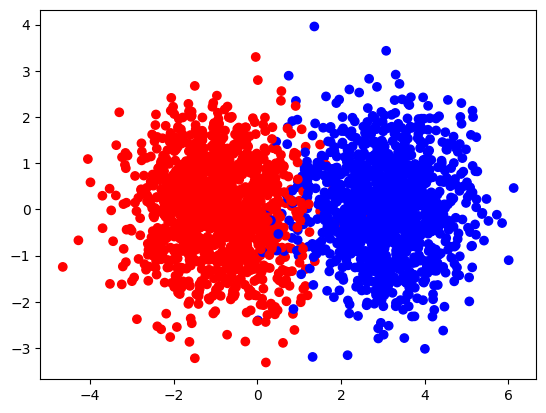

In [3]:
X_train, y_train, X_test, y_test = generate_data(2500, 500) #large test size to make diagrams better
print(X_train.shape)
print(X_test.shape)
plt.scatter(X_train[:,0], X_train[:,1], c=y_train, cmap='bwr');

### Training Logistic Regression

It's clear that the data is separable with a vertical line.  The simplest model we can use for this data is logistic regression.  Let's do that.

In [4]:
import tensorflow as tf
from tensorflow import keras

print(tf.__version__)

2024-11-12 00:33:20.882280: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731393200.895263   18782 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731393200.899042   18782 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-12 00:33:20.912150: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.18.0


In [7]:
#####
## MAKE SURE YOU UNDERSTAND THIS CODE!!
##
## Look up keras.Sequential and keras.layers.Dense!
##
## You will need to use them to write your own model down below!
#####

# Sequential models are ones where the set of specified layers are stacked each on top of the previous.
linear_model = keras.Sequential([
    # Dense is an affine (xW + b) layer followed by an element wise nonlinearity.
    keras.layers.Dense(1, activation='sigmoid')
])

# adam optimizer is a fancier version of gradient descent.  You can read more about it here: https://arxiv.org/pdf/1412.6980.pdf
linear_model.compile(optimizer='adam',
              loss='binary_crossentropy',  # From information theory notebooks.
              metrics=['accuracy'])        # What metric to output as we train.

linear_model.fit(X_train, y_train, epochs=15)

**Hint:** You should expect to see an initial loss here of 0.2 - 1.2.  This is because a well-initialized random classifier tends to output a uniform distribution.  For each example in the batch, we either compute the cross-entropy loss of the label (`[1, 0]` or `[0, 1]`) against the model's output (`~[0.5, 0.5]`).  Both cases result in $-\lg(0.5) = lg(2) = 1.0$.

Of course, your random classifier won't output exactly uniform distributions (it's random after all), but you should anticipate it being pretty close.  If it's not, your initialization may be broken and make it hard for your network to learn.

**[Optional]** Some technical details... if your randomly initialized network is outputting very confident predictions, the loss computed may be very large while at the same time the sigmoids in the network are likely in saturation, quickly shrinking gradients.  The result is that you make tiny updates in the face of a huge loss.

Let's use our model to make predictions on the test set:

In [8]:
predictions = linear_model.predict(X_test)
plt.scatter(X_test[:,0], X_test[:,1], c=predictions[:,0]>0.5, cmap='bwr')

### But what about a harder problem?

The case above, the data was linearly separable making it susceptible to a linear classifier.

But what if you had data that looked more like this?

In [10]:
X_train, y_train, X_test, y_test = generate_non_linear_data(2500, 500)
plt.scatter(X_test[:,0], X_test[:,1], c=y_test, cmap='bwr')

In [11]:
linear_model.fit(X_train, y_train, epochs=10)

Again, let's make predictions on the test set...

In [12]:
predictions = linear_model.predict(X_test)
plt.scatter(X_test[:,0], X_test[:,1], c=predictions[:,0]>0.5, cmap='bwr')

That isn't very good!

### Building a deeper network with the Sequential API

Ok, now it's your turn.  Build a sequential neural network below and start to build intuition around the effects of the number of layers in the network and the number of neurons in each layer.  Try to achieve a loss less than 0.05.  Initialization is random, but try to make it happen "almost" always (e.g. at least 90% of the time). Let's look first at the number of layers.

In [13]:
deep_model = keras.Sequential([
    #
    # Hint, try "relu" as your activation function.
    # relu(z) = max(0, z).
    #     Note that: relu(z) = z when z > 0
    #                relu(z) = 0 otherwise
    #
    # See https://en.wikipedia.org/wiki/File:Ramp_function.svg
    #
    # This is the most common nonlinearity for the main body of the network as its derivative is
    # either 0 or 1, depending on the value of z.
    #
    # This means that the gradient doesn't tend to explode or vanish as you multiply more partial
    # derivative terms together.
    #
    # For this problem...
    #
    # Try toying with the trade offs between more layers vs wider networks:
    #   If we keep repeating the same hidden layer with n neurons:
    #    What's the minimum number of hidden layers you can get away with given a larger value of n?
    #    For this exercise the value of n should be constant across all your layers and n > 5

    ### YOUR CODE HERE




    ### END YOUR CODE

    # Think about why you still use a sigmoid at the top of your network.
    keras.layers.Dense(1, activation='sigmoid')
])

deep_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

deep_model.fit(X_train, y_train, epochs=10)

In [14]:
predictions = deep_model.predict(X_test)
plt.scatter(X_test[:,0], X_test[:,1], c=predictions[:,0]>0.5, cmap='bwr')

**Question 4**: What is the minimum number of hidden layers with the same number of neurons in each you can get away with and still achieve the desired loss on the training set?  Enter your answer in the answers file.

In [15]:
narrow_model = keras.Sequential([
    #
    # Hint, try "relu" as your activation function.
    # relu(z) = max(0, z).
    #     Note that: relu(z) = z when z > 0
    #                relu(z) = 0 otherwise
    #
    # See https://en.wikipedia.org/wiki/File:Ramp_function.svg
    #
    # This is the most common nonlinearity for the main body of the network as its derivative is
    # either 0 or 1, depending on the value of z.
    #
    # This means that the gradient doesn't tend to explode or vanish as you multiply more partial
    # derivative terms together.
    #
    # For this problem...
    #
    # Try toying with the trade offs between more layers vs wider networks:
    #   If we keep repeating the same hidden layer with n neurons:
    #    What's the smallest number of neurons (n) in each layer you can use
    #     if you use four or more layers?

    ### YOUR CODE HERE



    ### END YOUR CODE

    # Think about why you still use a sigmoid at the top of your network.
    keras.layers.Dense(1, activation='sigmoid')
])

narrow_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

narrow_model.fit(X_train, y_train, epochs=10)

In [16]:
n_predictions = narrow_model.predict(X_test)
plt.scatter(X_test[:,0], X_test[:,1], c=n_predictions[:,0]>0.5, cmap='bwr')

**Question 5**: What is the smallest number of neurons you can use in a layer in the network with the largest number of layers and still get the desired loss on the training set?

### Keras Functional API

Finally, let's do some initial exploration of the Keras Functional API. The code above used a Sequential model, which is a simplified way to create a Tensorflow model using Keras. As you can see above, we can build a Sequential model just by listing some layers, which Keras will attach one after the other. If we want to do anything fancier, though, like have multiple inputs or outputs, we need to use the Functional API.

Let's imagine that we want to take the input features we used above, but now we want to pass the same input into two separate Dense layers, then concatenate the vectors that come out of them. There isn't a practical reason to do this right now, we're just getting familiar with some more Keras layer operations, that you might use in the future when you do have a reason (e.g. if you have two different types of input or you want to generate multiple different outputs).

With the Functional API, we first instantiate each layer, specifying any parameters like the dimension (number of neurons). Then, we "call" the layer we just created, using another set of parentheses to pass in whatever the input to that layer is. That's how we connect the layers, we save the output from one layer and then pass it as input to the layer that should come after. Essentially we will build our model by repeating:

```layer_output = layer(earlier_layer_output)```

The order in which we define the layers does not matter.  Once defined we can connect them.


We also have to explicitly define an input layer, so that we can pass it into the first hidden layer in the model. We also have to define an output layer.

You will redefine the sequential model you just created but do so using the functional API.



In [17]:
# Define the input layer
input_layer = keras.layers.Input(shape=(2,), dtype='int64')


#Here are the layers you should use

dense_1 = keras.layers.Dense(10, activation='relu')
dense_2 = keras.layers.Dense(10, activation='relu')
dense_3 = keras.layers.Dense(10, activation='relu')

# Now call the dense layers with the right input for each, to connect the network

### YOUR CODE HERE



### END YOUR CODE


# Define a binary classification layer like we used in the model above
classification_layer = keras.layers.Dense(1, activation='sigmoid')(dense_3_out)

You've defined all of your layers and connnected them together. Now you just need a few more lines of code to define the overall model, then compile it and train it like you did with the Sequential model.

To define the model, you specify the initial inputs and final outputs. You've already defined how the layers are connected internally, so as long as there's a path from the initial inputs to the final outputs, you're good.

In [18]:
# Define the complete model, specifying the overall inputs and outputs
func_model = tf.keras.models.Model(inputs=[input_layer], outputs=[classification_layer])

# Compile the model, specifying the loss, optimizer, etc to use in training
func_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

func_model.fit(X_train, y_train, epochs=10)

**Question 6**:  What is the final accuracy score you get after training the functional model for 10 epochs?  Please copy and paste your answer in to the answers file.

In [19]:
predictions = func_model.predict(X_test)
plt.scatter(X_test[:,0], X_test[:,1], c=predictions[:,0]>0.5, cmap='bwr')

# Congratulations...
... you've trained a nonlinear classifier with TensorFlow and Keras using the sequential and the functional APIs!